# Cancer Skin Predictor (with CNN)
##### This project focuses on skin cancer recognition using a Convolutional Neural Network (CNN) trained from scratch. The model classifies skin lesions as cancerous or non-cancerous using the HAM10000 dataset, which contains over 10,000 images of different skin conditions with pixel definitions. 

In [279]:
#libraries
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array

##### The model will be trained on hmnist_28_28_RGB.csv, which contains flattened pixel data for 28×28 RGB images (28×28×3 = 2352 features per image)

In [280]:
data = pd.read_csv('C:/Users/alkka/OneDrive/Pulpit/college_py/4sem/ai/project_ai/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


### 1. Prepare Cancer Data


##### 1.1 Replace labels  
##### Replace "label" column's values to determine if given skin pigmentation is a cancer or not, "label" values: 0:"akiec"(Actinic keratoses), 1:"bcc"(Basal cell carcinoma), 6:"mel" (Melanoma) stand for Cancer, however 4:"nv"(Melanocytic nevi (moles)), 2:"bkl"(Benign keratosis), 3:"df"(Dermatofibroma), 5:"vasc"(Vascular lesion) are not a cancer

In [281]:
# x and y division
y = data['label']
y = y.replace({0: 1, 1: 1, 6: 1, 2: 0, 3: 0, 4: 0, 5: 0}) # assign "1" for cancer, "0" for no cancer 
x = data.drop(columns = ['label'])
print('Shape of Data :',x.shape)

Shape of Data : (10015, 2352)


##### 1.2 Analyze images dataset

In [282]:
other = pd.read_csv('C:/Users/alkka/OneDrive/Pulpit/college_py/4sem/ai/project_ai/HAM10000_metadata.csv')
other.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


##### Perform overampling to balance dataset and avoid model becoming biased and achieving poor preformance

In [283]:
print('Shape of Data :',x.shape)
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)
x = np.array(x).reshape(-1,28,28,3)
print('Shape of Data after oversample :',x.shape)

Shape of Data : (10015, 2352)
Shape of Data after oversample : (16122, 28, 28, 3)


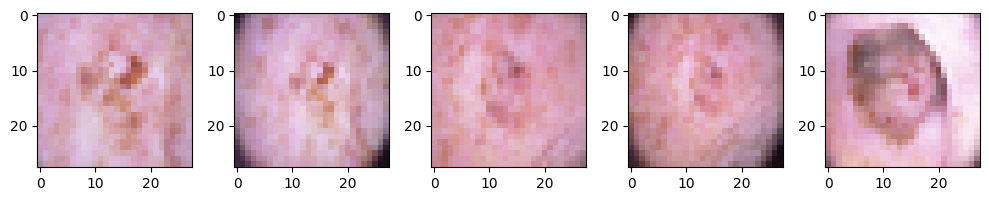

In [284]:
f, ax = plt.subplots(1, 5)  
f.set_size_inches(10, 2)  

k = 0
for j in range(5):  
    ax[j].imshow(x[k].reshape(28, 28, 3))  
    k += 1

plt.tight_layout()
plt.show()

##### Normalize

In [285]:
x = (x-np.mean(x))/np.std(x)

##### Divide into training and testing sets(80|20)

In [286]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=42)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5519342193241283..1.1065068718110886].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1322188391686336..2.104744248482921].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.285737585544973..0.6850288683274262].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.086090110210607..2.0160120372232027].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.287500208873141..1.9494628787784136].


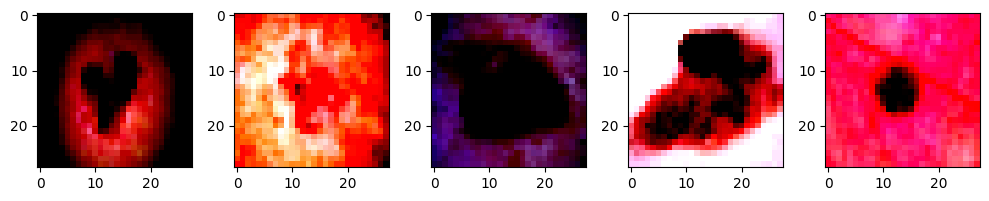

In [287]:
f , ax = plt.subplots(1,5)
f.set_size_inches(10, 2)

k = 0 
for j in range(5):
    ax[j].imshow(X_train[k].reshape(28,28,3))
    k = k + 1

plt.tight_layout()
plt.show()

### 2. CNN 

##### 2.1 CNN architecture
##### Conv2D layers detect important features in the image, like edges, textures, and color patterns, which help the model understand what is in the image. 
##### MaxPooling2D reduces the size of the image, keeping only the most important information, which makes the model more efficient and focused on key features. 
##### The Flatten layer turns the image's features into a one-dimensional list, so they can be processed by the next layers. 
##### The Dense layers analyze this list of features and make a decision about what the image shows, such as whether it’s a tumor or healthy skin.

In [288]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

c:\Users\alkka\OneDrive\Pulpit\college_py\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,576,578 (6.01 MB)

 Trainable params: 1,576,578 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

##### 2.2 Set Checkpoints
##### Saving the best model (by value loss) during training. Implementing EarlyStopping that stops training if value accuracy stops improving for 5 epochs.


In [289]:
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', mode='min', verbose=0)
callback = [Checkpoint, tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy", mode='max', verbose=1)]

### 3. Train the model

In [290]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    batch_size=224,
    epochs=50,
    callbacks=[callback],
    verbose=1
)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 389ms/step - accuracy: 0.6087 - loss: 0.6364 - val_accuracy: 0.7283 - val_loss: 0.4997
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 374ms/step - accuracy: 0.7524 - loss: 0.4744 - val_accuracy: 0.7721 - val_loss: 0.4495
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 373ms/step - accuracy: 0.7764 - loss: 0.4390 - val_accuracy: 0.7806 - val_loss: 0.4459
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 351ms/step - accuracy: 0.7919 - loss: 0.4249 - val_accuracy: 0.7814 - val_loss: 0.4735
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 338ms/step - accuracy: 0.7982 - loss: 0.4172 - val_accuracy: 0.7996 - val_loss: 0.4251
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.8206 - loss: 0.3821 - val_accuracy: 0.8105 - val_loss: 0.4076
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 389ms/step - accuracy: 0.8396 - loss: 0.3510 - val_accuracy: 0.8326 - val_loss: 0.3824
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.8698 - loss: 0.3065 - val_accu

### 4. Evaluate the model

In [291]:
loaded_model = load_model("best_model.keras")
print("CNN model loaded successfully!")

CNN model loaded successfully!


#### 4.1 Check for accuracy

In [292]:
test_loss, test_acc = loaded_model.evaluate(X_test, Y_test, verbose=0)

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc:.2f}")
print(f"Final Validation Accuracy: {val_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Final Training Accuracy: 1.00
Final Validation Accuracy: 0.93
Test Accuracy: 0.94


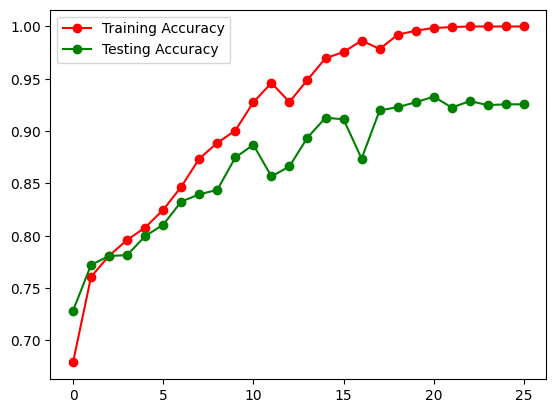

In [293]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

#### 4.2 Classification report 

In [294]:
classes = {0: ('no_cancer'),  1: ('cancer'), }
Y_pred  = model.predict(X_test).round()
Y_pred_labels = np.argmax(Y_pred, axis=1)
print(classification_report(Y_test, Y_pred_labels, target_names=["no_cancer", "cancer"]))

101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
              precision    recall  f1-score   support

   no_cancer       0.98      0.90      0.94      1639
      cancer       0.90      0.98      0.94      1586

    accuracy                           0.94      3225
   macro avg       0.94      0.94      0.94      3225
weighted avg       0.94      0.94      0.94      3225



#### 4.3 Confusion matrix

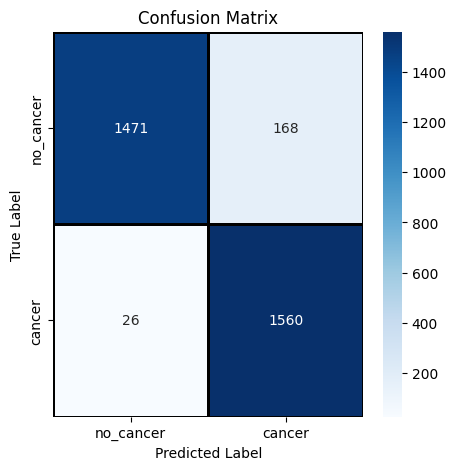

In [295]:
cm = confusion_matrix(Y_test, Y_pred_labels)
cm_df = pd.DataFrame(cm, index=["no_cancer", "cancer"], columns=["no_cancer", "cancer"])
plt.figure(figsize=(5, 5))
sns.heatmap(cm_df, cmap="Blues", annot=True, fmt="d", linecolor='black', linewidth=1)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### 5. Final notes


##### The model achieved a final training accuracy of ~100% and validation accuracy of ~93%, indicating a strong learning capability. On the test set, it maintained a high accuracy of ~94%. The model demonstrated robust performance across both classes, with a precision of ~0.98 for non-cancer and ~0.90 for cancer cases, and high recall values of ~0.90 and ~0.98, respectively. The balanced F1-scores ~0.94 and consistent macro and weighted averages confirm the model’s effectiveness and reliability in distinguishing between cancerous and non-cancerous skin cases.

### 6. Example image testing

#### 6.1 Load image

In [296]:
image_path = 'C:/Users/alkka/OneDrive/Pulpit/college_py/4sem/ai/project_ai/my_pic.jpg'  # replace if needed, you can paste path to your own skin pigmentation image
img = load_img(image_path, target_size=(28, 28))

#### 6.2 Process image

In [297]:
img = load_img(image_path, target_size=(28, 28))
img_array = img_to_array(img) / 255.0  # normalize to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # shape becomes (1, 28, 28, 3)
# + standardize
img_array = (img_array - np.mean(img_array)) / np.std(img_array)

#### 6.3 Get result 

In [298]:
prediction = loaded_model.predict(img_array)
predicted_class = classes[np.argmax(prediction)]
print(f"Predicted: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Predicted: no_cancer
